In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")

In [3]:
# Загрузка и подготовка данных
df = pd.read_csv('clean_train_final.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715283 entries, 0 to 715282
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   name                   715283 non-null  object
 1   type                   715283 non-null  object
 2   category_l2            715283 non-null  object
 3   category_l4            715283 non-null  object
 4   is_markup              715283 non-null  bool  
 5   target                 715283 non-null  int64 
 6   stratify_column        715283 non-null  object
 7   name_processed         715283 non-null  object
 8   type_processed         715283 non-null  object
 9   category_l2_processed  715283 non-null  object
 10  category_l4_processed  715283 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 55.3+ MB


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Количество символов
df['name_char_len'] = df['name'].str.len()
df['type_char_len'] = df['type'].str.len()

# Количество слов
df['name_word_count'] = df['name'].str.split().apply(len)
df['type_word_count'] = df['type'].str.split().apply(len)

# Средняя длина слова
df['name_avg_word_len'] = df['name'].apply(lambda x: sum(len(w) for w in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
df['type_avg_word_len'] = df['type'].apply(lambda x: sum(len(w) for w in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Максимальная и минимальная длина слова
df['name_max_word_len'] = df['name'].apply(lambda x: max([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
df['type_max_word_len'] = df['type'].apply(lambda x: max([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

df['name_min_word_len'] = df['name'].apply(lambda x: min([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
df['type_min_word_len'] = df['type'].apply(lambda x: min([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

# Различия и отношения между длинами
df['char_len_diff'] = abs(df['name_char_len'] - df['type_char_len'])
df['word_count_diff'] = abs(df['name_word_count'] - df['type_word_count'])
df['char_len_ratio'] = df['name_char_len'] / (df['type_char_len'] + 1)
df['word_count_ratio'] = df['name_word_count'] / (df['type_word_count'] + 1)

# Количество цифр и спецсимволов
df['name_digit_count'] = df['name'].str.count(r'\d')
df['type_digit_count'] = df['type'].str.count(r'\d')

df['name_spec_count'] = df['name'].str.count(r'[^A-Za-zА-Яа-я0-9 ]')
df['type_spec_count'] = df['type'].str.count(r'[^A-Za-zА-Яа-я0-9 ]')

# Флаги наличия цифр и спецсимволов
df['name_has_digit'] = df['name_digit_count'] > 0
df['type_has_digit'] = df['type_digit_count'] > 0
df['name_has_spec'] = df['name_spec_count'] > 0
df['type_has_spec'] = df['type_spec_count'] > 0

# Количество общих слов
def count_common_words(row):
    name_words = set(row['name'].split())
    type_words = set(row['type'].split())
    return len(name_words.intersection(type_words))

common_word_count = df.apply(count_common_words, axis=1).values.reshape(-1, 1)


length_features = df[[
    'name_char_len',
    'type_char_len',
    'name_word_count',
    'type_word_count',
    'name_avg_word_len',
    'type_avg_word_len',
    'name_max_word_len',
    'type_max_word_len',
    'name_min_word_len',
    'type_min_word_len',
    'char_len_diff',
    'word_count_diff',
    'char_len_ratio',
    'word_count_ratio',
    'name_digit_count',
    'type_digit_count',
    'name_spec_count',
    'type_spec_count',
    'name_has_digit',
    'type_has_digit',
    'name_has_spec',
    'type_has_spec'
    ]]

 Основные статистики по признакам длины:


count       mean        std       min        25%  \
name_char_len      715283.0  66.920268  38.444667  1.000000  39.000000   
type_char_len      715283.0  17.749867   9.029101  1.000000  10.000000   
name_word_count    715283.0   9.637293   5.571005  1.000000   6.000000   
type_word_count    715283.0   2.339487   1.197112  1.000000   1.000000   
name_avg_word_len  715283.0   6.286081   1.558071  1.000000   5.333333   
type_avg_word_len  715283.0   7.354846   2.248172  1.000000   6.000000   
name_max_word_len  715283.0  11.467805   3.627140  1.000000   9.000000   
type_max_word_len  715283.0   9.225593   2.893546  1.000000   7.000000   
name_min_word_len  715283.0   2.354222   1.874332  1.000000   1.000000   
type_min_word_len  715283.0   5.440472   2.902250  1.000000   3.000000   
char_len_diff      715283.0  50.026459  39.070796  0.000000  21.000000   
word_count_diff    715283.0   7.393861   5.652548  0.000000   3.000000   
char_len_ratio     715283.0   4.783936   4.458635  0.025000   2.000000   
word_count_ratio   715283.0   3.315012   2.486068  0.090909   1.600000   
name_digit_count   715283.0   4.514905   5.864111  0.000000   0.000000   
type_digit_count   715283.0   0.001388   0.040472  0.000000   0.000000   
name_spec_count    715283.0   2.586246   2.616064  0.000000   0.000000   
type_spec_count    715283.0   0.068163   0.277675  0.000000   0.000000   

                         50%        75%     max  
name_char_len      58.000000  88.000000  313.00  
type_char_len      17.000000  23.000000   72.00  
name_word_count     8.000000  13.000000   55.00  
type_word_count     2.000000   3.000000   10.00  
name_avg_word_len   6.058824   7.000000   80.00  
type_avg_word_len   7.000000   8.250000   27.00  
name_max_word_len  11.000000  13.000000  157.00  
type_max_word_len   9.000000  11.000000   33.00  
name_min_word_len   2.000000   3.000000   80.00  
type_min_word_len   5.000000   7.000000   27.00  
char_len_diff      40.000000  70.000000  294.00  
word_count_diff     6.000000  10.000000   52.00  
char_len_ratio      3.277778   5.850000   60.25  
word_count_ratio    2.600000   4.166667   24.00  
name_digit_count    3.000000   6.000000  190.00  
type_digit_count    0.000000   0.000000    2.00  
name_spec_count     2.000000   4.000000   50.00  
type_spec_count     0.000000   0.000000    5.00


Цифровые значения статистик:
                      count       mean        std       min        25%        50%        75%     max
name_char_len      715283.0  66.920268  38.444667  1.000000  39.000000  58.000000  88.000000  313.00
type_char_len      715283.0  17.749867   9.029101  1.000000  10.000000  17.000000  23.000000   72.00
name_word_count    715283.0   9.637293   5.571005  1.000000   6.000000   8.000000  13.000000   55.00
type_word_count    715283.0   2.339487   1.197112  1.000000   1.000000   2.000000   3.000000   10.00
name_avg_word_len  715283.0   6.286081   1.558071  1.000000   5.333333   6.058824   7.000000   80.00
type_avg_word_len  715283.0   7.354846   2.248172  1.000000   6.000000   7.000000   8.250000   27.00
name_max_word_len  715283.0  11.467805   3.627140  1.000000   9.000000  11.000000  13.000000  157.00
type_max_word_len  715283.0   9.225593   2.893546  1.000000   7.000000   9.000000  11.000000   33.00
name_min_word_len  715283.0   2.354222   1.874332  1.000000  

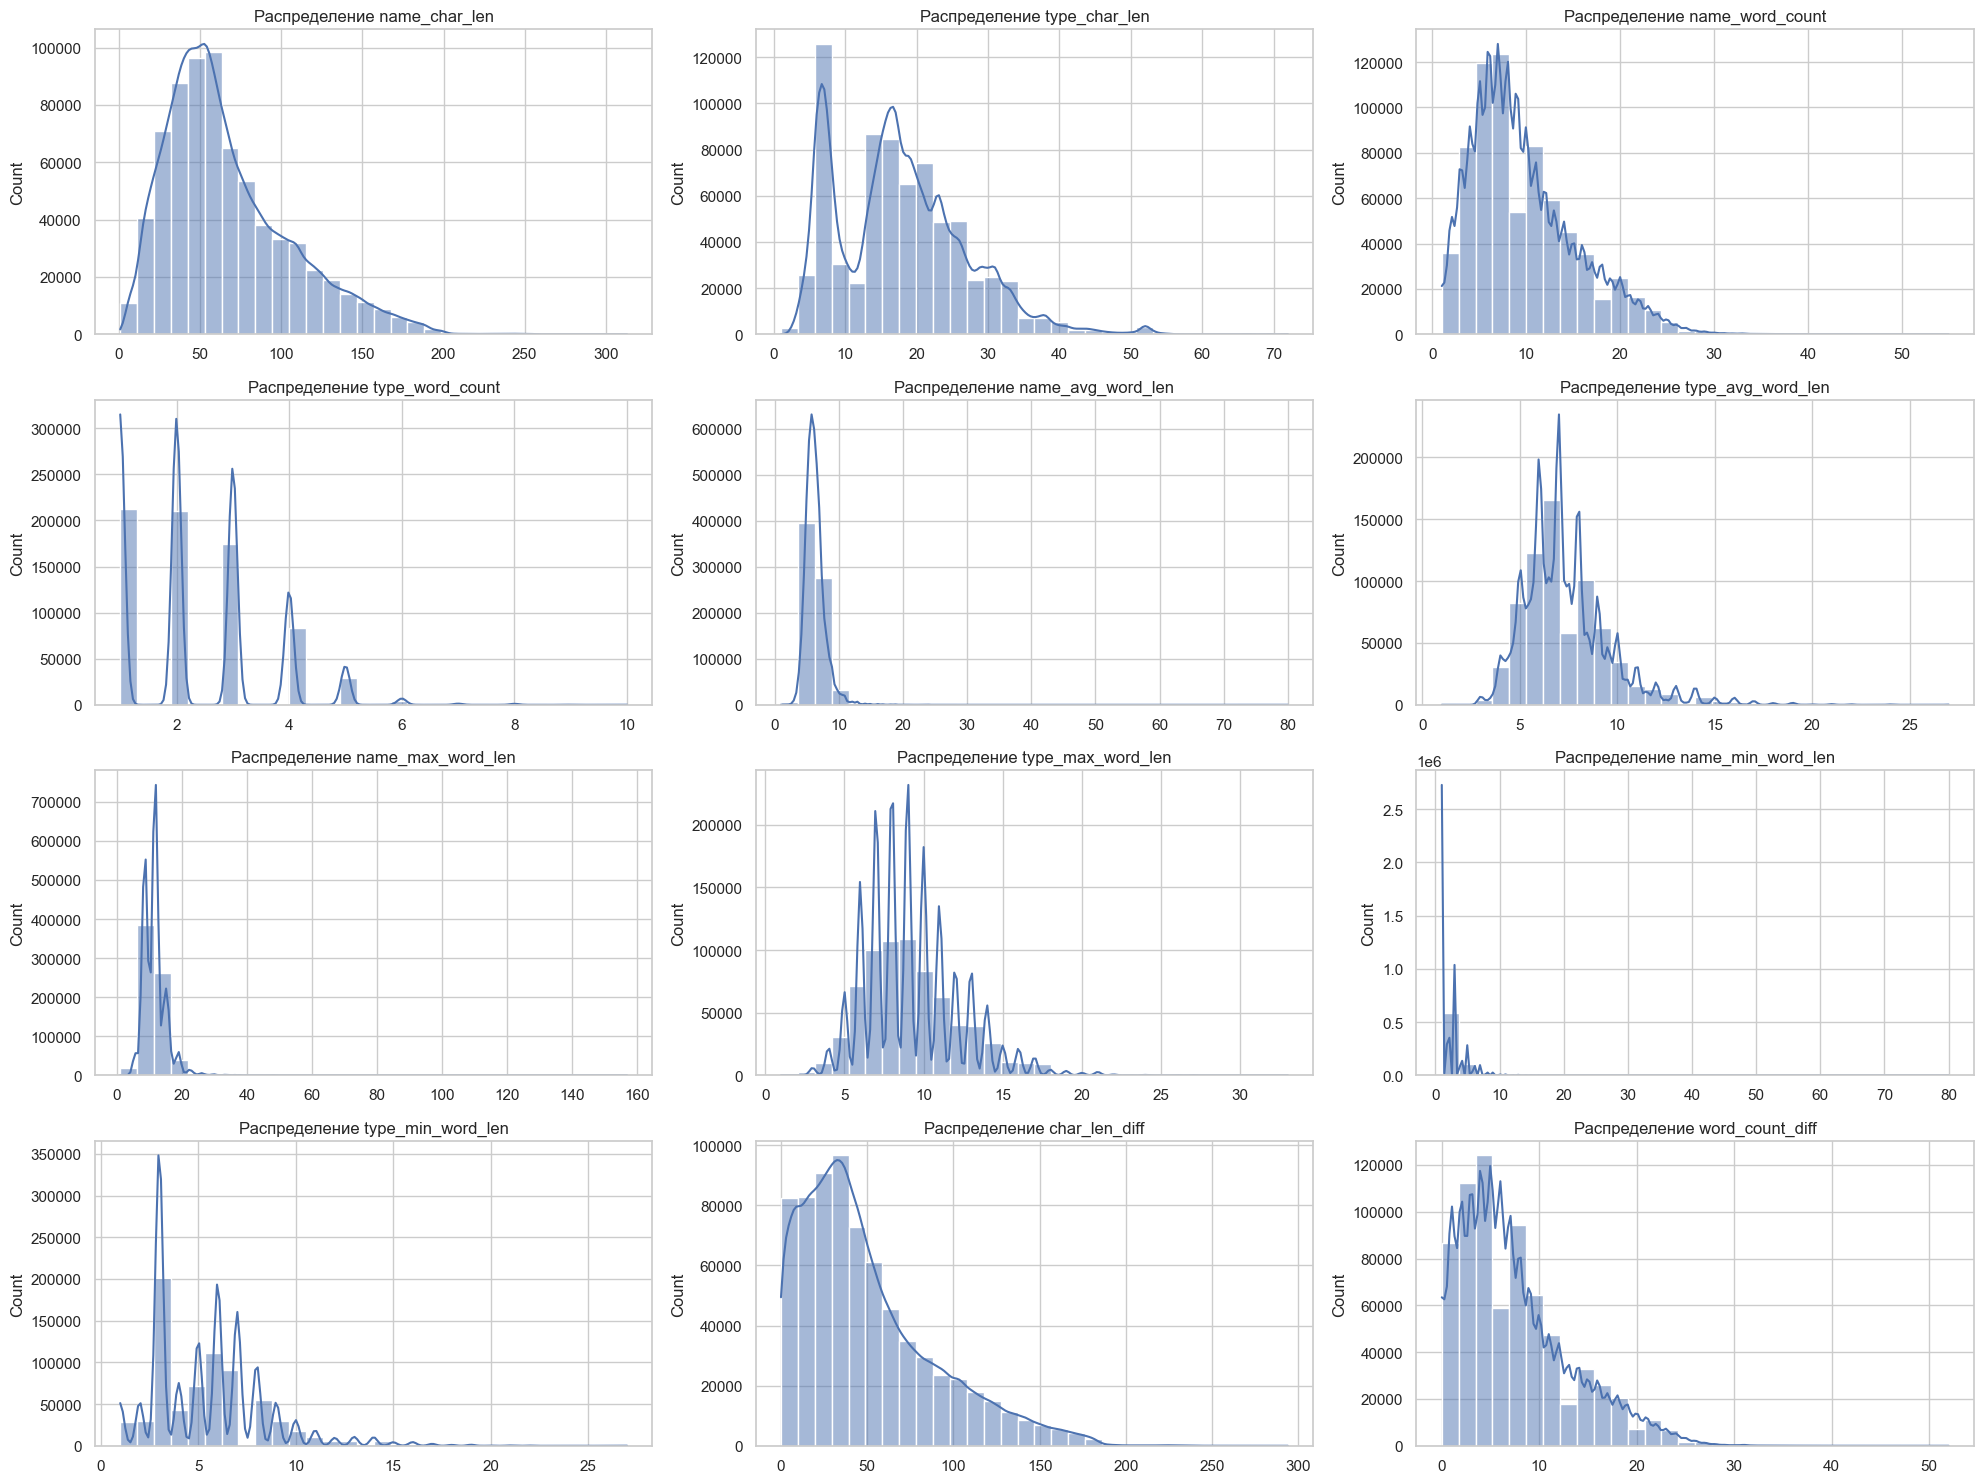


Статистики по числовым признакам:
       name_char_len  type_char_len  name_word_count  type_word_count  name_avg_word_len  type_avg_word_len  name_max_word_len  type_max_word_len  name_min_word_len  type_min_word_len  char_len_diff  word_count_diff
count  715283.000000  715283.000000    715283.000000    715283.000000      715283.000000      715283.000000      715283.000000      715283.000000      715283.000000      715283.000000  715283.000000    715283.000000
mean       66.920268      17.749867         9.637293         2.339487           6.286081           7.354846          11.467805           9.225593           2.354222           5.440472      50.026459         7.393861
std        38.444667       9.029101         5.571005         1.197112           1.558071           2.248172           3.627140           2.893546           1.874332           2.902250      39.070796         5.652548
min         1.000000       1.000000         1.000000         1.000000           1.000000           1.

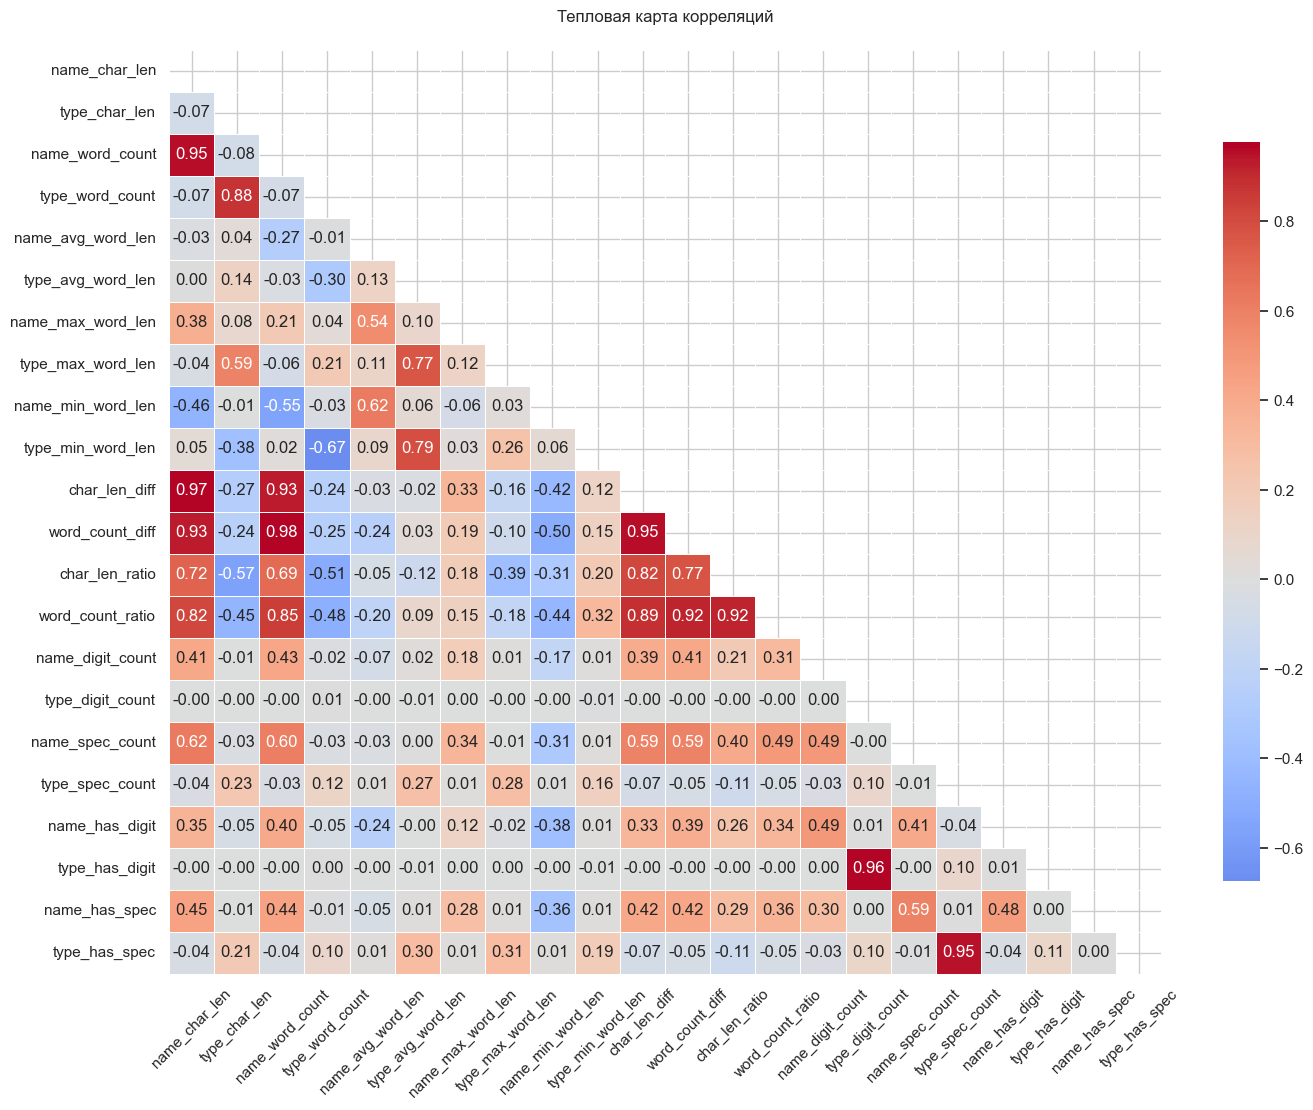


Корреляционная матрица:
                   name_char_len  type_char_len  name_word_count  type_word_count  name_avg_word_len  type_avg_word_len  name_max_word_len  type_max_word_len  name_min_word_len  type_min_word_len  char_len_diff  word_count_diff  char_len_ratio  word_count_ratio  name_digit_count  type_digit_count  name_spec_count  type_spec_count  name_has_digit  type_has_digit  name_has_spec  type_has_spec
name_char_len           1.000000      -0.074799         0.953101        -0.074559          -0.026628           0.003338           0.376297          -0.041312          -0.459653           0.045166       0.973371         0.933615        0.717738          0.821476          0.411058         -0.003774         0.616376        -0.035259        0.351885       -0.004229       0.447176      -0.042049
type_char_len          -0.074799       1.000000        -0.080336         0.875838           0.039078           0.137726           0.077949           0.588166          -0.006884          -

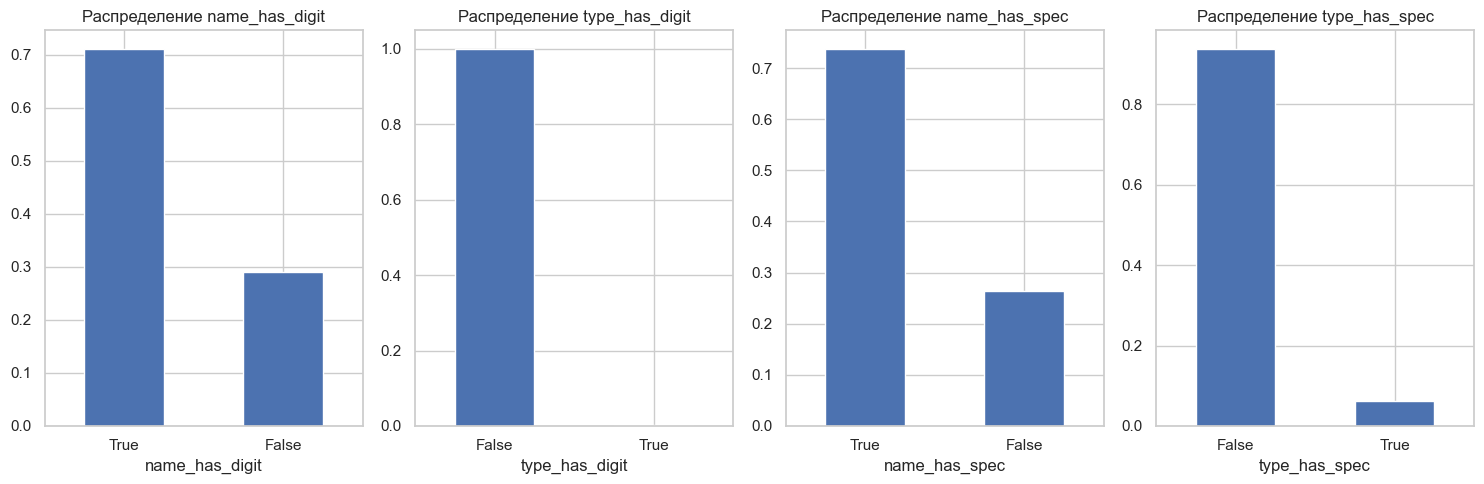


Распределение категориальных признаков:

name_has_digit:
name_has_digit
True     0.710425
False    0.289575

type_has_digit:
type_has_digit
False    0.998738
True     0.001262

name_has_spec:
name_has_spec
True     0.73676
False    0.26324

type_has_spec:
type_has_spec
False    0.937432
True     0.062568


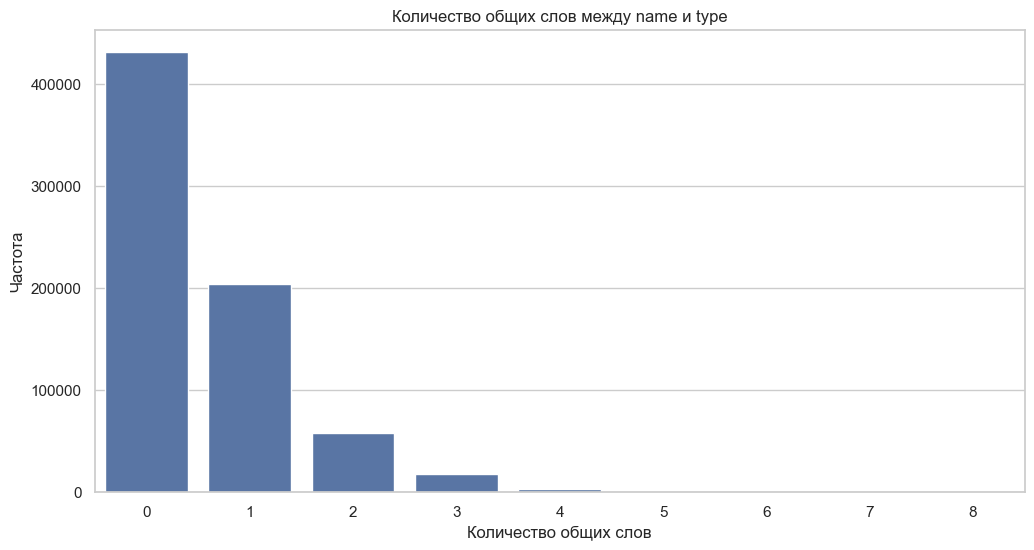


Статистики по общим словам:
count    715283.000000
mean          0.544563
std           0.795239
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           8.000000


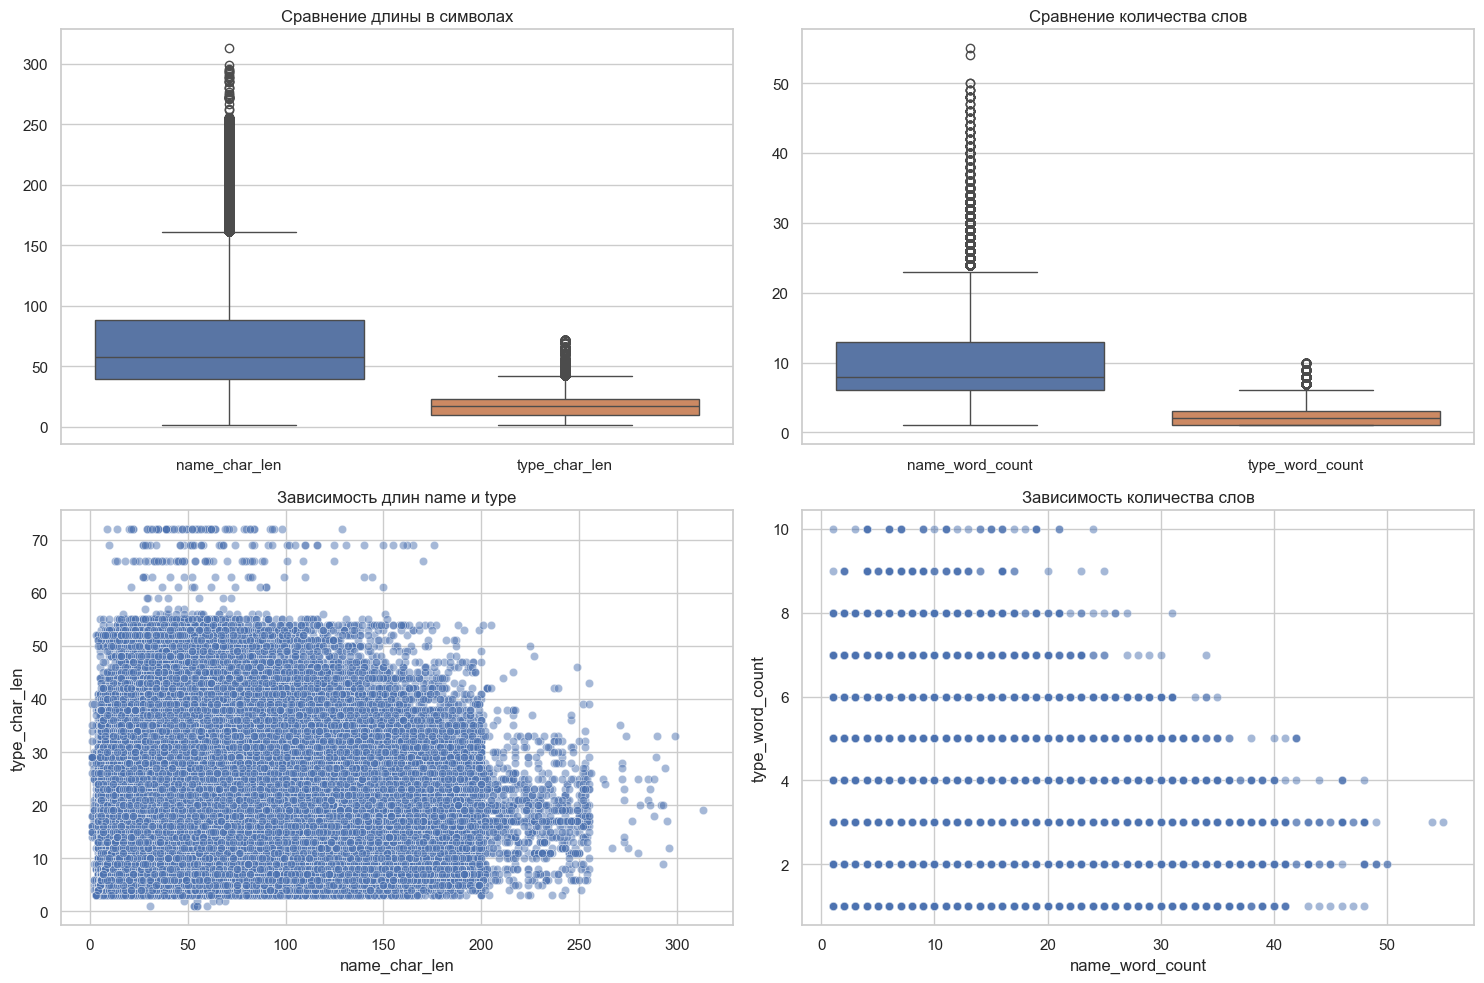


Статистики сравнения name и type:
       name_char_len  type_char_len  name_word_count  type_word_count
count  715283.000000  715283.000000    715283.000000    715283.000000
mean       66.920268      17.749867         9.637293         2.339487
std        38.444667       9.029101         5.571005         1.197112
min         1.000000       1.000000         1.000000         1.000000
25%        39.000000      10.000000         6.000000         1.000000
50%        58.000000      17.000000         8.000000         2.000000
75%        88.000000      23.000000        13.000000         3.000000
max       313.000000      72.000000        55.000000        10.000000


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Настройка отображения
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')  # Устанавливаем тему seaborn

# 1. Основные статистики
print(" Основные статистики по признакам длины:")
stats = length_features.describe().T
display(stats)
print("\nЦифровые значения статистик:")
print(stats.to_string())

# 2. Распределения числовых признаков
num_features = length_features.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_features[:12], 1):  # Первые 12 признаков
    plt.subplot(4, 3, i)
    sns.histplot(length_features[col], bins=30, kde=True)
    plt.title(f'Распределение {col}')
    plt.xlabel('')
plt.tight_layout()
plt.show()

print("\nСтатистики по числовым признакам:")
print(length_features[num_features[:12]].describe().to_string())

# 3. Корреляционная матрица
plt.figure(figsize=(16, 12))
corr_matrix = length_features.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Тепловая карта корреляций', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

print("\nКорреляционная матрица:")
print(corr_matrix.to_string())

# 4. Анализ категориальных признаков
cat_features = length_features.select_dtypes(include=['bool']).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(cat_features, 1):
    plt.subplot(1, 4, i)
    length_features[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Распределение {col}')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nРаспределение категориальных признаков:")
for col in cat_features:
    print(f"\n{col}:")
    print(length_features[col].value_counts(normalize=True).to_string())

# 5. Анализ общих слов
plt.figure(figsize=(12, 6))
sns.countplot(x=common_word_count.flatten())
plt.title('Количество общих слов между name и type')
plt.xlabel('Количество общих слов')
plt.ylabel('Частота')
plt.show()

print("\nСтатистики по общим словам:")
print(pd.Series(common_word_count.flatten()).describe().to_string())

# 6. Сравнение name и type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=df[['name_char_len', 'type_char_len']], ax=axes[0, 0])
axes[0, 0].set_title('Сравнение длины в символах')

sns.boxplot(data=df[['name_word_count', 'type_word_count']], ax=axes[0, 1])
axes[0, 1].set_title('Сравнение количества слов')

sns.scatterplot(data=df, x='name_char_len', y='type_char_len', alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Зависимость длин name и type')

sns.scatterplot(data=df, x='name_word_count', y='type_word_count', alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Зависимость количества слов')
plt.tight_layout()
plt.show()

print("\nСтатистики сравнения name и type:")
print(df[['name_char_len', 'type_char_len', 'name_word_count', 'type_word_count']].describe().to_string())

#### 1. Структурные различия `name` и `type` — фундаментальны
Статистика убедительно доказывает, что название и тип товара имеют совершенно разную структуру.

- **Название (`name`)** — **длинное и описательное**. В среднем содержит **~67 символов** и **~10 слов**, включая множество цифр (в 71% случаев) и спецсимволов.
- **Тип (`type`)** — **короткий и стандартизированный**. В среднем состоит из **~18 символов** и **~2-3 слов**, практически не содержит цифр и спецсимволов.

> **Вывод:** Эти структурные различия являются сильным сигналом для модели.

In [6]:
# Эмбеддинги
emb_name = np.load('final_name.npy')
emb_type = np.load('final_type.npy')

# Косинусное сходство между эмбеддингами name и type
cos_sim = np.array([cosine_similarity(emb_name[i].reshape(1, -1), emb_type[i].reshape(1, -1))[0][0]
                    for i in range(len(df))])

Анализ косинусного сходства между эмбеддингами name и type

1. Основные статистики косинусного сходства:
count    715283.000000
mean          0.538743
std           0.191346
min          -0.082321
25%           0.404307
50%           0.540466
75%           0.674702
max           1.000000

2. Распределение по квантилям:
0.01    0.116671
0.05    0.218745
0.25    0.404307
0.50    0.540466
0.75    0.674702
0.95    0.844503
0.99    1.000000

3. Примеры записей:
Топ-5 максимальных сходств:
               name         type  cosine_similarity
323233  Мастурбатор  Мастурбатор                1.0
470985  Мастурбатор  Мастурбатор                1.0
109366  Мастурбатор  Мастурбатор                1.0
676026  Мастурбатор  Мастурбатор                1.0
604417  Мастурбатор  Мастурбатор                1.0

Топ-5 минимальных сходств:
                                                                                                                                                                name       

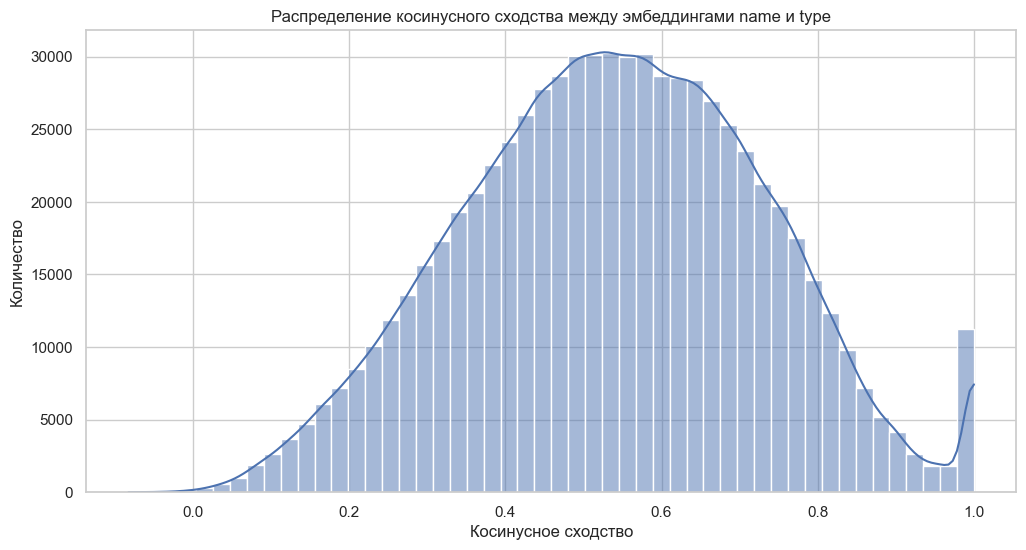


Корреляция с целевой переменной: 0.5293


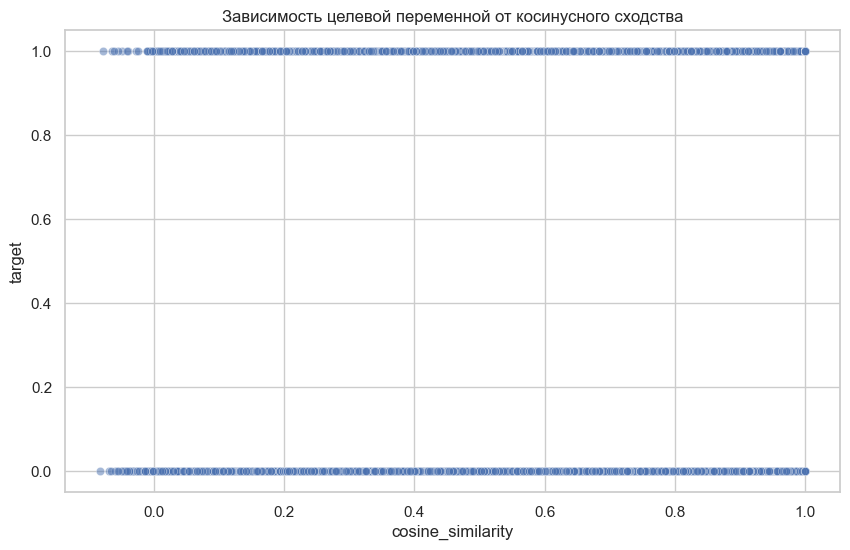


Среднее сходство по категориям L2:
category_l2
Ювелирные изделия                   0.794448
Товары для взрослых                 0.629174
Товары для курения и аксессуары     0.629165
Одежда                              0.617108
Галантерея и аксессуары             0.615256
Автотовары                          0.603836
Обувь                               0.597464
Фермерское хозяйство                0.578992
Строительство и ремонт              0.568744
Дом и сад                           0.568307
Бытовая техника                     0.541788
Канцелярские товары                 0.539373
Хобби и творчество                  0.537857
Детские товары                      0.536683
Мебель                              0.534302
Спорт и отдых                       0.531888
Кино, музыка, видеоигры, софт       0.521064
unknown                             0.517504
Продукты питания Ozon Fresh         0.514982
Красота и гигиена                   0.512767
Бытовая химия                       0.509410
Продукт

In [12]:
# Добавляем результаты в DataFrame
df['cosine_similarity'] = cos_sim

# Анализ статистик
print("="*50)
print("Анализ косинусного сходства между эмбеддингами name и type")
print("="*50)

# 1. Основные статистики
print("\n1. Основные статистики косинусного сходства:")
cos_stats = pd.Series(cos_sim).describe()
print(cos_stats.to_string())

# 2. Распределение по квантилям
print("\n2. Распределение по квантилям:")
quantiles = pd.Series(cos_sim).quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print(quantiles.to_string())

# 3. Примеры с максимальным и минимальным сходством
print("\n3. Примеры записей:")
print("Топ-5 максимальных сходств:")
max_idx = np.argsort(cos_sim)[-5:]
print(df.iloc[max_idx][['name', 'type', 'cosine_similarity']].to_string())

print("\nТоп-5 минимальных сходств:")
min_idx = np.argsort(cos_sim)[:5]
print(df.iloc[min_idx][['name', 'type', 'cosine_similarity']].to_string())

# 4. Визуализация
plt.figure(figsize=(12, 6))
sns.histplot(cos_sim, bins=50, kde=True)
plt.title('Распределение косинусного сходства между эмбеддингами name и type')
plt.xlabel('Косинусное сходство')
plt.ylabel('Количество')
plt.show()

# 5. Корреляция с целевой переменной (если есть)
if 'target' in df.columns:
    corr = df['cosine_similarity'].corr(df['target'])
    print(f"\nКорреляция с целевой переменной: {corr:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='cosine_similarity', y='target', data=df, alpha=0.5)
    plt.title('Зависимость целевой переменной от косинусного сходства')
    plt.show()

# 6. Анализ по категориям (если нужно)
if 'category_l2' in df.columns:
    print("\nСреднее сходство по категориям L2:")
    print(df.groupby('category_l2')['cosine_similarity'].mean().sort_values(ascending=False).to_string())

#### 2. Семантическая схожесть — ключ к решению
Анализ косинусной схожести показал высочайшую предсказательную ценность этого признака.

- **Сильная корреляция с `target`:** Коэффициент **0.53** подтверждает, что смысловая близость — главный фактор для определения правильности типа.
- **Логичное распределение по категориям:** Схожесть максимальна для категорий с прямым соответствием (например, `Ювелирные изделия` — **0.79**) и минимальна для категорий с абстрактными типами (например, `Книги` — **0.34**).

> **Вывод:** Косинусная схожесть будет одним из самых важных признаков.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Кодирование категориальных признаков с помощью LabelEncoder
le_l2 = LabelEncoder()
le_l4 = LabelEncoder()
le_l2_type = LabelEncoder()
le_l4_type = LabelEncoder()
le_l2_l4 = LabelEncoder()

df['category_l2_enc'] = le_l2.fit_transform(df['category_l2'])
df['category_l4_enc'] = le_l4.fit_transform(df['category_l4'])

# Взаимодействия категорий и типов

# category_l2 + type
df['l2_type'] = df['category_l2'].astype(str) + '_' + df['type'].astype(str)
df['l2_type_enc'] = le_l2_type.fit_transform(df['l2_type'])

# category_l4 + type
df['l4_type'] = df['category_l4'].astype(str) + '_' + df['type'].astype(str)
df['l4_type_enc'] = le_l4_type.fit_transform(df['l4_type'])

# category_l2 + category_l4
df['l2_l4'] = df['category_l2'].astype(str) + '_' + df['category_l4'].astype(str)
df['l2_l4_enc'] = le_l2_l4.fit_transform(df['l2_l4'])

# Вывод результатов кодирования
print("="*50)
print("Результаты кодирования категориальных признаков:")
print("="*50)

# 1. Отображение соответствий для category_l2
print("\nКодировка category_l2:")
l2_mapping = dict(zip(le_l2.classes_, le_l2.transform(le_l2.classes_)))
for category, code in l2_mapping.items():
    print(f"{category}: {code}")

# 2. Отображение соответствий для category_l4
print("\nКодировка category_l4:")
l4_mapping = dict(zip(le_l4.classes_, le_l4.transform(le_l4.classes_)))
for category, code in l4_mapping.items():
    print(f"{category}: {code}")

# 3. Отображение соответствий для l2_type
print("\nКодировка l2_type (первые 20 значений):")
l2_type_mapping = dict(zip(le_l2_type.classes_, le_l2_type.transform(le_l2_type.classes_)))
for i, (combo, code) in enumerate(l2_type_mapping.items()):
    if i < 20:  # Ограничиваем вывод первыми 20 значениями
        print(f"{combo}: {code}")
    else:
        print(f"... и еще {len(l2_type_mapping)-20} комбинаций")
        break

# 4. Отображение соответствий для l4_type
print("\nКодировка l4_type (первые 20 значений):")
l4_type_mapping = dict(zip(le_l4_type.classes_, le_l4_type.transform(le_l4_type.classes_)))
for i, (combo, code) in enumerate(l4_type_mapping.items()):
    if i < 20:
        print(f"{combo}: {code}")
    else:
        print(f"... и еще {len(l4_type_mapping)-20} комбинаций")
        break

# 5. Отображение соответствий для l2_l4
print("\nКодировка l2_l4 (первые 20 значений):")
l2_l4_mapping = dict(zip(le_l2_l4.classes_, le_l2_l4.transform(le_l2_l4.classes_)))
for i, (combo, code) in enumerate(l2_l4_mapping.items()):
    if i < 20:
        print(f"{combo}: {code}")
    else:
        print(f"... и еще {len(l2_l4_mapping)-20} комбинаций")
        break

# 6. Статистика по закодированным признакам
cat_type_features = df[['category_l2_enc', 'category_l4_enc', 'l2_type_enc', 'l4_type_enc', 'l2_l4_enc']].values

print("\n" + "="*50)
print("Статистика по закодированным признакам:")
print("="*50)
print("\nКоличество уникальных значений в каждом признаке:")
print(f"category_l2_enc: {len(l2_mapping)} уникальных категорий")
print(f"category_l4_enc: {len(l4_mapping)} уникальных категорий")
print(f"l2_type_enc: {len(l2_type_mapping)} уникальных комбинаций")
print(f"l4_type_enc: {len(l4_type_mapping)} уникальных комбинаций")
print(f"l2_l4_enc: {len(l2_l4_mapping)} уникальных комбинаций")

print("\nПримеры закодированных данных (первые 5 строк):")
print(df[['category_l2', 'category_l2_enc', 
          'category_l4', 'category_l4_enc',
          'l2_type', 'l2_type_enc',
          'l4_type', 'l4_type_enc',
          'l2_l4', 'l2_l4_enc']].sample(5))

Результаты кодирования категориальных признаков:

Кодировка category_l2:
unknown: 0
Автомототехника: 1
Автотовары: 2
Антиквариат и коллекционирование: 3
Аптека: 4
Бытовая техника: 5
Бытовая химия: 6
Галантерея и аксессуары: 7
Детские товары: 8
Дом и сад: 9
Канцелярские товары: 10
Кино, музыка, видеоигры, софт: 11
Книги: 12
Красота и гигиена: 13
Мебель: 14
Музыкальные инструменты: 15
Обувь: 16
Одежда: 17
Продукты питания: 18
Продукты питания Ozon Fresh: 19
Спорт и отдых: 20
Строительство и ремонт: 21
Товары для взрослых: 22
Товары для животных: 23
Товары для курения и аксессуары: 24
Фермерское хозяйство: 25
Хобби и творчество: 26
Электроника: 27
Ювелирные изделия: 28

Кодировка category_l4:
(ВЕТ) Гормональные препараты: 0
(ВЕТ) Иммуностимуляторы, противовоспалительные: 1
(ВЕТ) Препараты для глаз и ушей: 2
(ВЕТ) Препараты для мочеполовой системы: 3
(ВЕТ) Препараты от глистов: 4
(ВЕТ) Препараты от клещей и блох: 5
(ВЕТ) Препараты от паразитов: 6
3D Пазл: 7
3D Ручка: 8
3D принтер: 9
3D-при

In [10]:
print(df['category_l2'].value_counts())

category_l2
unknown                             320575
Дом и сад                            71800
Автотовары                           54325
Строительство и ремонт               46534
Электроника                          34273
Одежда                               31364
Детские товары                       17162
Мебель                               15742
Красота и гигиена                    15594
Галантерея и аксессуары              14964
Хобби и творчество                   14754
Спорт и отдых                        14616
Обувь                                13497
Товары для животных                   8418
Бытовая техника                       8280
Канцелярские товары                   7953
Аптека                                6342
Книги                                 5251
Товары для взрослых                   4302
Продукты питания                      2677
Антиквариат и коллекционирование      1361
Бытовая химия                         1195
Музыкальные инструменты               1076

Проверить результат достаточнот сложно, так как у нас unknown встречется 320575 раз в колонке.  

In [11]:
import pandas as pd

# Вычисление статистик и добавление их в DataFrame
# Средние значения
df['type_target_mean'] = df.groupby('type')['target'].transform('mean')
df['name_target_mean'] = df.groupby('name')['target'].transform('mean')
df['category_l2_target_mean'] = df.groupby('category_l2')['target'].transform('mean')
df['category_l4_target_mean'] = df.groupby('category_l4')['target'].transform('mean')

# Дополнительные статистики
df['type_count'] = df.groupby('type')['target'].transform('count')
df['type_target_var'] = df.groupby('type')['target'].transform('var').fillna(0)
df['name_target_max'] = df.groupby('name')['target'].transform('max')
df['name_target_min'] = df.groupby('name')['target'].transform('min')

# Комбинированные статистики
df['l2_type_target_mean'] = df.groupby(['category_l2', 'type'])['target'].transform('mean')
df['l4_type_target_mean'] = df.groupby(['category_l4', 'type'])['target'].transform('mean')
df['l2_type_count'] = df.groupby(['category_l2', 'type'])['target'].transform('count')
df['l4_type_count'] = df.groupby(['category_l4', 'type'])['target'].transform('count')

# Отношения частот
df['category_l2_count'] = df.groupby('category_l2')['target'].transform('count')
df['category_l4_count'] = df.groupby('category_l4')['target'].transform('count')
df['type_to_category_l2_ratio'] = df['type_count'] / (df['category_l2_count'] + 1)
df['type_to_category_l4_ratio'] = df['type_count'] / (df['category_l4_count'] + 1)

# Вывод статистик
print("="*80)
print("Агрегированные статистики по target")
print("="*80)

# 1. Статистики по type
print("\n1. Статистики по type:")
type_stats = df.groupby('type')['target'].agg(['mean', 'count', 'var', 'min', 'max', 'std'])
print(type_stats.to_string())

# 2. Статистики по name (топ-20)
print("\n2. Статистики по name (топ-20 по частоте):")
name_stats = df.groupby('name')['target'].agg(['mean', 'count', 'min', 'max', 'std'])
print(name_stats.sort_values('count', ascending=False).head(20).to_string())

# 3. Статистики по category_l2
print("\n3. Статистики по category_l2:")
l2_stats = df.groupby('category_l2')['target'].agg(['mean', 'count', 'min', 'max', 'std'])
print(l2_stats.to_string())

# 4. Статистики по category_l4
print("\n4. Статистики по category_l4:")
l4_stats = df.groupby('category_l4')['target'].agg(['mean', 'count', 'min', 'max', 'std'])
print(l4_stats.to_string())

# 5. Статистики по комбинациям (category_l2, type)
print("\n5. Статистики по комбинациям (category_l2, type) (топ-20 по частоте):")
l2_type_stats = df.groupby(['category_l2', 'type'])['target'].agg(['mean', 'count', 'min', 'max'])
print(l2_type_stats.sort_values('count', ascending=False).head(20).to_string())

# 6. Статистики по комбинациям (category_l4, type)
print("\n6. Статистики по комбинациям (category_l4, type) (топ-20 по частоте):")
l4_type_stats = df.groupby(['category_l4', 'type'])['target'].agg(['mean', 'count', 'min', 'max'])
print(l4_type_stats.sort_values('count', ascending=False).head(20).to_string())

# 7. Отношения частот
print("\n7. Отношения частот:")
print(f"Среднее отношение частоты type к частоте category_l2: {df['type_to_category_l2_ratio'].mean():.4f}")
print(f"Среднее отношение частоты type к частоте category_l4: {df['type_to_category_l4_ratio'].mean():.4f}")

# 8. Общая статистика по всем новым признакам
print("\n8. Общая статистика по сгенерированным признакам:")
new_features = df[['type_target_mean', 'name_target_mean', 'category_l2_target_mean', 
                  'category_l4_target_mean', 'type_count', 'type_target_var', 
                  'name_target_max', 'name_target_min', 'l2_type_target_mean',
                  'l4_type_target_mean', 'l2_type_count', 'l4_type_count',
                  'type_to_category_l2_ratio', 'type_to_category_l4_ratio']]
print(new_features.describe().to_string())

# Примеры строк с новыми признаками
print("\n9. Пример данных с новыми признаками (первые 5 строк):")
sample_cols = ['type', 'name', 'category_l2', 'category_l4', 'target',
               'type_target_mean', 'name_target_mean', 'l2_type_target_mean',
               'type_count', 'l2_type_count']
print(df[sample_cols].head().to_string())

Агрегированные статистики по target

1. Статистики по type:
                                                                              mean  count       var  min  max       std
type                                                                                                                   
0                                                                         0.000000      6  0.000000    0    0  0.000000
3D очки                                                                   0.200000      5  0.200000    0    1  0.447214
3D очки для проектора                                                     0.000000      1       NaN    0    0       NaN
3D пазл                                                                   0.875000     24  0.114130    0    1  0.337832
3D принтер                                                                0.000000      2  0.000000    0    0  0.000000
3D раскраска                                                              0.285714      7  0.238095 

#### 3. Статистика использования типов (`Target Encoding`) выявляет "хорошие" и "плохие" типы
Агрегированные данные показывают, что некоторые типы исторически используются продавцами более корректно, чем другие.

- **Пример "хорошего" типа:** `3D пазл` используется правильно в **87.5%** случаев.
- **Пример "плохого" типа:** `3D-ручка` — только в **15.8%** случаев.

> **Вывод:** Эта информация является чрезвычайно мощным признаком, что требует использования безопасных техник (кросс-валидация) для избежания утечки данных.

#### Итоговое заключение

Анализ подтвердил правильность выбранной стратегии. Данные содержат сильные и явные сигналы, которые можно извлечь с помощью инжиниринга признаков. **Структурные различия, семантическая схожесть и статистика использования типов являются тремя столпами, на которых будет строиться высокоточная предсказательная модель.** 

Изначально мы пошли немного другим путем и хотели сначала выучить категории, чтобы не было проблем и так явно выпирающего Unknown, но с получением объяснения, что это можно игнорировать, мы смогли выстроить работу над предсказательной моделью для таргета